<a href="https://colab.research.google.com/github/cjayjonathan/Counting-Coins/blob/main/Counting_Coins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math


In [2]:
uploaded = files.upload()
filename = 'NO SELECTION YET'

Saving dan-dennis-pZ56pVKd_6c-unsplash.jpg to dan-dennis-pZ56pVKd_6c-unsplash.jpg


In [14]:
def coin_counter(image):
  morph_size = 20
  MinThresholdV = 85
  element = cv2.getStructuringElement( cv2.MORPH_RECT,(morph_size,morph_size))
  img = cv2.imread(image,1) # we read the image in a variable
  img = cv2.GaussianBlur(img,(5,5),0) # we blur the image to reduce the noise and other false structure
  img = cv2.bilateralFilter(img,5,6,6) # we use filter to enhance the edges of the coins to identify easily
  hsv = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2HSV)
  hsv_split = cv2.split(hsv)
  img1 = cv2.inRange(hsv_split[2], MinThresholdV, 255)
  image_pre_hsv = cv2.morphologyEx(img1, cv2.MORPH_OPEN, element)
  img_prepr = img.copy() # create a copy of image for the reference
  img_prepr = cv2.cvtColor(img_prepr,cv2.COLOR_BGR2GRAY) # convert the image to greyscale for easy preprocess
  img_prepr = cv2.morphologyEx(img_prepr, cv2.MORPH_OPEN, element)
  fig = plt.figure(figsize=(12, 6), dpi=80)
  ax = fig.add_subplot(121, aspect='auto')
  ax.imshow(img)
  ax.set_title("Original image")
  coins = cv2.HoughCircles(img_prepr,cv2.HOUGH_GRADIENT,0.5,20,param1=50,param2=30,minRadius=30,maxRadius=100) # used hough circles for identify the coins in the image
  coin_location = np.uint16(np.around(coins)) # save the location of each circles in a variable
  coins_count = 0
  for i in coin_location[0,:]: # iterate the coins location for marking the circle and also counting
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),10)
  coins_count+=1
  ax = fig.add_subplot(122, aspect='auto')
  ax.imshow(img, cmap='gray')
  ax.set_title("Number of coins in image - "+ str(coins_count))
  return [image_pre_hsv,hsv_split,coin_location]

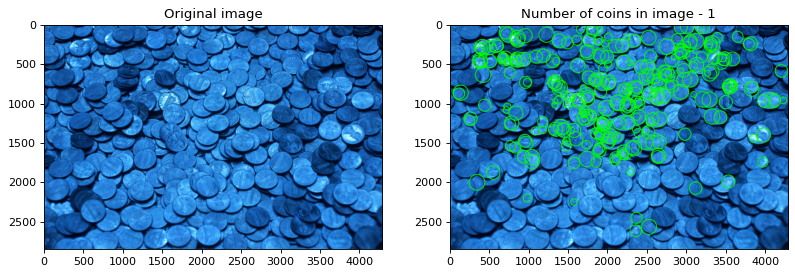

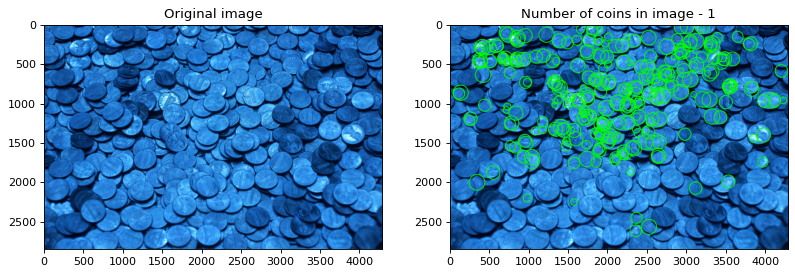

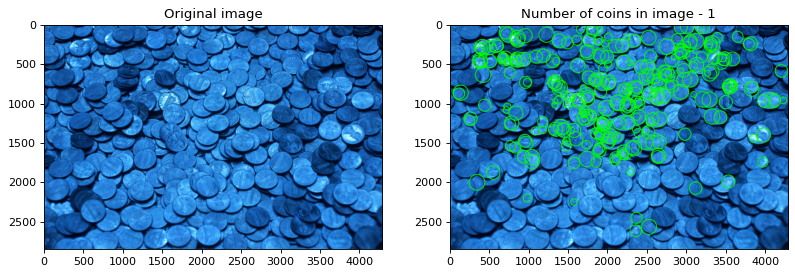

In [15]:
bin_img = []
filename=[]
img_HSV = []
img_coin_location = []
for image in uploaded.keys():
  filename.append(image)
  preprocess_image = coin_counter(image)[0]
  bin_img.append(preprocess_image)
  hsv_split = coin_counter(image)[1]
  img_HSV.append(hsv_split)
  hsv_coin_location = coin_counter(image)[2]
  img_coin_location.append(hsv_coin_location)


In [78]:
#input: ROI coords (top left, width, height), blob area, image number
#output: coin value (-1 if unknown), mean Sat at centre, mean sat on sides
#accesses Saturation image as well
def classify(x,y,w,h,area,img_idx):
    size = (w+h)/2
    #check Saturation in center
    im = img_HSV[img_idx][1] #Sat component
    sub_img = im[y+h//3:y+2*h//3, x+w//3:x+2*w//3]
    mcenter = cv2.mean(sub_img)
    meanSatcenter = mcenter[0]
    #check Saturation in 4 sides
    sub_img = im[y+h//3:y+2*h//3, x+5:x+w//5] #left
    mside = cv2.mean(sub_img)
    meanSatside = mside[0]
    sub_img = im[y+4*h//5:y+h-5, x+w//3:x+2*w//3] #down
    mside = cv2.mean(sub_img)
    meanSatside = meanSatside + mside[0]
    sub_img = im[y+h//3:y+2*h//3, x+4*w//5:x+w-5] #right
    mside = cv2.mean(sub_img)
    meanSatside = meanSatside + mside[0]
    sub_img = im[y+5:y+h//5, x+w//3:x+2*w//3] #top
    mside = cv2.mean(sub_img)
    meanSatside = meanSatside + mside[0]
    meanSatside = meanSatside // 4
    #classify using sizes and Sat
    if size < 80 or size > 160: #too small or too large
        return (-1, 0, 0)
    if size < 96: #it's a 5p
        return (0.05, meanSatcenter ,meanSatside)
    if size < 108: #it's a 1p
        if meanSatcenter < 100: #not coloured, 5p
            return (0.05, meanSatcenter ,meanSatside)
    else: #1p
        return (0.01, meanSatcenter ,meanSatside)
    if size < 116: #it's a 20p or a 1p, use Sat
        if meanSatcenter < 130: #not coloured, 20p
            return (0.2, meanSatcenter ,meanSatside)
    else: #coloured, 1p
        return (0.01, meanSatcenter ,meanSatside)
    if size < 138: #it can be £1, 10p or 2p, use Sat
    #different Sat border/centre
        if ((meanSatside - meanSatcenter) > 10) and (meanSatcenter < 100) and (size < 130):
            return (1.0, meanSatcenter ,meanSatside) #£1
    #center and border similar
    if meanSatcenter < 94: #center not coloured, 10p
            return (0.1, meanSatcenter ,meanSatside) #10p
    else: #center has colour, 2p
            return (0.02, meanSatcenter ,meanSatside)
    #if code reaches here, it's either 50p or £2
    if ((meanSatside - meanSatcenter > 10)): #different Sat border/centre
            return (2.0, meanSatcenter ,meanSatside) #£2
    else:
        if meanSatcenter < 100: #center not coloured, 50p
            return (0.5, meanSatcenter ,meanSatside)
        else: 
      #might be a large 2p
            return (0.02, meanSatcenter ,meanSatside)


Blob [1324 1026   36]too small!
Blob [1494 1030   34]too small!
Blob [2924  588   32]too small!
Blob [2260  876   33]too small!
Blob [3084  892   37]too small!
Blob [2830  420   34]too small!
Blob [724 488  38]too small!
Blob [3258  624   37]too small!
Blob [668 460  35]too small!
Blob [1818 1170   38]too small!
Blob [2590  886   36]too small!
Blob [2238  164   38]too small!
Blob [1332  978   33]too small!
Blob [3178   46   35]too small!
Blob [3178   46   35] IS COIN
-1
Unknown value!
Value=-1
TOTAL: £-1





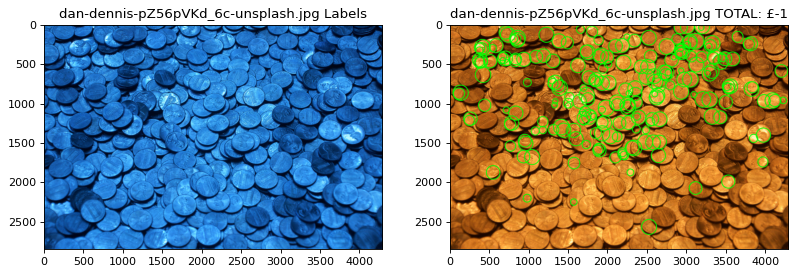

In [84]:
for num_image in range(len(filename)):
    image_to_use = num_image
    coin_location = img_coin_location[image_to_use]
    imgRGB=cv2.cvtColor(cv2.imread(filename[image_to_use]), cv2.COLOR_BGR2RGB)
    TotalValue = 0
    labels_img = filename[image_to_use]
    labels_img = cv2.imread(labels_img,1)
    dic = {}
    for i in coin_location[0,:]: # iterate the coins location for marking the circle and also counting
        x1 = i[0]
        y1 = i[1]
        w = i[2]*2
        h = i[2]*2
        # print(x1)
        # print(y1)
        if x1+w in dic:
            continue
        cv2.circle(imgRGB,(i[0],i[1]),i[2],(0,255,0),10)


        for allre in range(x1+w-10,x1+w):
            dic[allre] = True


        area = math.pi*i[2]**2
        if abs(w-h)>20: #too unsquare
            # pass
            print('Blob '+str(i) +'too unsquare!')
        else:
            size = (h + w)/2
            if size < 80:
# pass
                print('Blob '+str(i) +'too small!')
else:
                print('Blob '+ str(i) +' IS COIN')
draw_ROI = 1
(value, SatC, SatSide) = classify(x1,y1,w,h,area,image_to_use)
print(value)
if value == -1 :
# pass
                print('Unknown value!')
else :
                cv2.putText(imgRGB, str(value), (int(x1),int(y1+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,0),6)
print('Value=' + str(value))
TotalValue = TotalValue + value
fig = plt.figure(figsize=(12, 6), dpi=80)
ax = fig.add_subplot(121, aspect='auto')
ax.imshow(labels_img, cmap='flag', vmin=0, vmax=255)
ax.set_title(filename[image_to_use] + ' Labels')
ax = fig.add_subplot(122, aspect='auto')
ax.imshow(imgRGB)
ax.set_title(filename[image_to_use] +' TOTAL: £' +str(TotalValue))
print('TOTAL: £' +str(TotalValue))
print("\n\n")